In [84]:
import math
import io
import shutil
import os
import sys
from os import path
import json

import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas as pd

import torch
from torch import nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
)

device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [85]:
df = pd.read_csv(path.join('dataset', 'EVSE-B-HPC-Kernel-Events-processed.csv'))
df

,irq_softirq_exit,irq_softirq_entry,irq_softirq_raise,kmem_kmem_cache_free,kmem_kmem_cache_alloc,net_netif_rx,net_netif_rx_ni_exit,net_netif_rx_ni_entry,rpm_rpm_usage,rpm_rpm_resume,...,Scenario_DoS,Scenario_Recon,Label_attack,Label_benign,interface_any,interface_iso15118,interface_iso15118,interface_none,interface_ocpp,isDoS
0,5808,5808,5826,3976,4016,0,0,0,4277,4369,...,False,False,True,False,True,False,False,False,False,False
1,4791,4791,4808,12217,13581,0,0,0,1355,1391,...,False,False,True,False,True,False,False,False,False,False
2,6635,6635,6667,16222,16487,0,0,0,2683,2719,...,False,False,True,False,True,False,False,False,False,False
3,9165,9165,9228,15833,17867,0,0,0,4934,4988,...,False,False,True,False,True,False,False,False,False,False
4,8405,8405,8431,16182,15720,0,0,0,4736,4778,...,False,False,True,False,True,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6161,95032,95032,95043,109798,109887,44337,44335,44335,80240,80266,...,True,False,True,False,False,False,False,False,True,True
6162,96744,96744,96779,98202,98220,37797,37795,37795,69827,69873,...,True,False,True,False,False,False,False,False,True,True
6163,99936,99935,99947,105024,104998,41208,41208,41208,75511,75531,...,True,False,True,False,False,False,False,False,True,True
6164,96575,96576,96590,99527,99583,38825,38825,38825,71057,71074,...,True,False,True,False,False,False,False,False,True,True


In [86]:
df.info

<bound method DataFrame.info of       irq_softirq_exit  irq_softirq_entry  irq_softirq_raise  \
0                 5808               5808               5826   
1                 4791               4791               4808   
2                 6635               6635               6667   
3                 9165               9165               9228   
4                 8405               8405               8431   
...                ...                ...                ...   
6161             95032              95032              95043   
6162             96744              96744              96779   
6163             99936              99935              99947   
6164             96575              96576              96590   
6165             97650              97650              97661   

      kmem_kmem_cache_free  kmem_kmem_cache_alloc  net_netif_rx  \
0                     3976                   4016             0   
1                    12217                  13581             0  

In [87]:
# 1. Device config
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [88]:
# Load your data
df = pd.read_csv("processed_evse.csv")

# Drop leakage or suspicious columns
leakage_cols = ['Scenario_DoS']
df.drop(columns=leakage_cols, inplace=True)

# Separate features and labels
X = df.drop(columns=['isDoS']).values
y = df['isDoS'].values

# Train/val/test split
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.25, random_state=42, stratify=y_temp)

# Convert to tensors
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.long)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64)
test_loader = DataLoader(test_dataset, batch_size=64)


Correlation with isDoS:
isDoS                            1.000000
Scenario_DoS                     1.000000
irq_softirq_exit                 0.859581
irq_softirq_entry                0.859580
irq_softirq_raise                0.859389
kmem_kmem_cache_free             0.855467
kmem_kmem_cache_alloc            0.855211
net_netif_rx                     0.830698
net_netif_rx_ni_exit             0.830678
net_netif_rx_ni_entry            0.830678
rpm_rpm_usage                    0.817357
rpm_rpm_resume                   0.817284
interface_ocpp                   0.667460
Attack_icmp-flood                0.360437
Attack_push-ack-flood            0.358996
Attack_syn-flood                 0.357551
Attack_synonymous-ip-flood       0.351713
Attack_udp-flood                 0.348761
Attack_icmp-fragmentation        0.347276
Label_attack                     0.311791
Attack_icmp-fragmentation_old    0.247453
Attack_tcp-flood                 0.149445
State_idle                       0.002634
State_Char

In [89]:
X

,irq_softirq_exit,irq_softirq_entry,irq_softirq_raise,kmem_kmem_cache_free,kmem_kmem_cache_alloc,net_netif_rx,net_netif_rx_ni_exit,net_netif_rx_ni_entry,rpm_rpm_usage,rpm_rpm_resume,...,Scenario_Benign,Scenario_Cryptojacking,Scenario_Recon,Label_attack,Label_benign,interface_any,interface_iso15118,interface_iso15118,interface_none,interface_ocpp
0,5808,5808,5826,3976,4016,0,0,0,4277,4369,...,False,True,False,True,False,True,False,False,False,False
1,4791,4791,4808,12217,13581,0,0,0,1355,1391,...,False,True,False,True,False,True,False,False,False,False
2,6635,6635,6667,16222,16487,0,0,0,2683,2719,...,False,True,False,True,False,True,False,False,False,False
3,9165,9165,9228,15833,17867,0,0,0,4934,4988,...,False,True,False,True,False,True,False,False,False,False
4,8405,8405,8431,16182,15720,0,0,0,4736,4778,...,False,True,False,True,False,True,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6161,95032,95032,95043,109798,109887,44337,44335,44335,80240,80266,...,False,False,False,True,False,False,False,False,False,True
6162,96744,96744,96779,98202,98220,37797,37795,37795,69827,69873,...,False,False,False,True,False,False,False,False,False,True
6163,99936,99935,99947,105024,104998,41208,41208,41208,75511,75531,...,False,False,False,True,False,False,False,False,False,True
6164,96575,96576,96590,99527,99583,38825,38825,38825,71057,71074,...,False,False,False,True,False,False,False,False,False,True


In [90]:
# 3. PyTorch Dataset
class EVSEDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y.values, dtype=torch.long)

    def __len__(self): return len(self.y)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_dataset = EVSEDataset(X_train, y_train)
test_dataset  = EVSEDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader  = DataLoader(test_dataset, batch_size=64)


In [91]:
# 4. Hybrid Transformer + MLP Model
class HybridTransformerClassifier(nn.Module):
    def __init__(self, input_dim, embed_dim=16, num_heads=4, hidden_dim=128, num_layers=1):
        super(HybridTransformerClassifier, self).__init__()
        self.embedding = nn.Linear(input_dim, embed_dim)
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=embed_dim, nhead=num_heads, dim_feedforward=hidden_dim
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.mlp = nn.Sequential(
            nn.Linear(embed_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 2)
        )

    def forward(self, x):
        # x shape: (batch_size, input_dim)
        x = self.embedding(x).unsqueeze(1)  # (B, 1, embed_dim)
        x = self.transformer(x).squeeze(1)  # (B, embed_dim)
        out = self.mlp(x)                   # (B, 2)
        return out

model = HybridTransformerClassifier(input_dim=X.shape[1]).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)


c:\ProgramData\anaconda3\envs\dl_gpu_env\lib\site-packages\torch\nn\modules\transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


In [92]:
def train(num_epochs=20):
    best_f1 = 0
    for epoch in range(num_epochs):
        model.train()
        total_loss = 0
        preds, trues = [], []

        for xb, yb in train_loader:
            xb, yb = xb.to(device), yb.to(device)
            logits = model(xb)
            loss = criterion(logits, yb)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            pred = logits.argmax(dim=1).detach().cpu().numpy()
            preds.extend(pred)
            trues.extend(yb.detach().cpu().numpy())

        # Metrics after epoch
        acc = accuracy_score(trues, preds)
        prec = precision_score(trues, preds)
        rec = recall_score(trues, preds)
        f1 = f1_score(trues, preds)

        print(f"Epoch {epoch+1}/{num_epochs} | Loss: {total_loss:.4f} | Acc: {acc:.4f} | Prec: {prec:.4f} | Rec: {rec:.4f} | F1: {f1:.4f}")

        if f1 > best_f1:
            best_f1 = f1
            torch.save(model.state_dict(), "best_evse_model.pth")


In [93]:
train(num_epochs=10)

# Final evaluation on test set
model.load_state_dict(torch.load("best_evse_model.pth"))
model.eval()
preds, trues = [], []

with torch.no_grad():
    for xb, yb in test_loader:
        xb = xb.to(device)
        out = model(xb)
        pred = out.argmax(1).cpu().numpy()
        preds.extend(pred)
        trues.extend(yb.numpy())

acc = accuracy_score(trues, preds)
prec = precision_score(trues, preds)
rec = recall_score(trues, preds)
f1 = f1_score(trues, preds)

print("\n✅ Final Evaluation on Test Set:")
print(f"Accuracy:  {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall:    {rec:.4f}")
print(f"F1-score:  {f1:.4f}")


Epoch 1/10 | Loss: 9.3045 | Acc: 0.9566 | Prec: 0.8855 | Rec: 0.7934 | F1: 0.8369
Epoch 2/10 | Loss: 1.2633 | Acc: 0.9955 | Prec: 0.9718 | Rec: 0.9971 | F1: 0.9843
Epoch 3/10 | Loss: 0.1666 | Acc: 1.0000 | Prec: 1.0000 | Rec: 1.0000 | F1: 1.0000
Epoch 4/10 | Loss: 0.0681 | Acc: 1.0000 | Prec: 1.0000 | Rec: 1.0000 | F1: 1.0000
Epoch 5/10 | Loss: 0.0392 | Acc: 1.0000 | Prec: 1.0000 | Rec: 1.0000 | F1: 1.0000
Epoch 6/10 | Loss: 0.0260 | Acc: 1.0000 | Prec: 1.0000 | Rec: 1.0000 | F1: 1.0000
Epoch 7/10 | Loss: 0.0195 | Acc: 1.0000 | Prec: 1.0000 | Rec: 1.0000 | F1: 1.0000
Epoch 8/10 | Loss: 0.0143 | Acc: 1.0000 | Prec: 1.0000 | Rec: 1.0000 | F1: 1.0000
Epoch 9/10 | Loss: 0.0111 | Acc: 1.0000 | Prec: 1.0000 | Rec: 1.0000 | F1: 1.0000
Epoch 10/10 | Loss: 0.0270 | Acc: 1.0000 | Prec: 1.0000 | Rec: 1.0000 | F1: 1.0000

✅ Final Evaluation on Test Set:
Accuracy:  1.0000
Precision: 1.0000
Recall:    1.0000
F1-score:  1.0000


C:\Users\r\AppData\Local\Temp\ipykernel_18968\3084988316.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("best_evse_model.pth"))


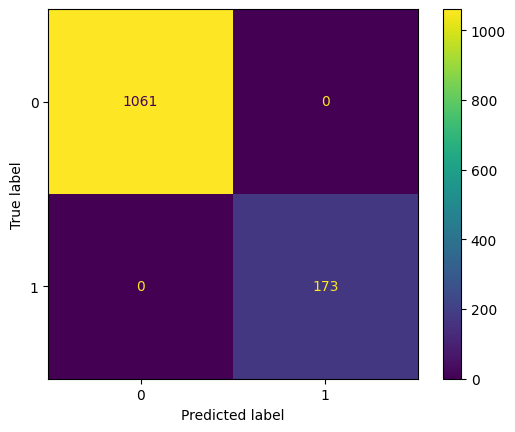

In [94]:
from sklearn.metrics import ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_predictions(y_test, preds)


In [95]:
print("Leakage columns dropped:", leak_cols)


Leakage columns dropped: ['Scenario_DoS']


In [96]:
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import torch
import numpy as np

# Use your filtered dataframe (df_filtered) without leakage columns
X = df_filtered.drop(columns=["isDoS"]).values
y = df_filtered["isDoS"].astype(int).values

scaler = StandardScaler()

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Your model class here: HybridTransformerClassifier
# Assuming it is defined exactly as before and takes input_dim as param

def train_one_epoch(model, optimizer, criterion, loader):
    model.train()
    total_loss = 0
    preds, trues = [], []

    for xb, yb in loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        logits = model(xb)
        loss = criterion(logits, yb)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        pred = logits.argmax(dim=1).detach().cpu().numpy()
        preds.extend(pred)
        trues.extend(yb.detach().cpu().numpy())
    acc = accuracy_score(trues, preds)
    prec = precision_score(trues, preds)
    rec = recall_score(trues, preds)
    f1 = f1_score(trues, preds)
    return total_loss, acc, prec, rec, f1

def eval_model(model, loader):
    model.eval()
    preds, trues = [], []
    with torch.no_grad():
        for xb, yb in loader:
            xb = xb.to(device)
            out = model(xb)
            pred = out.argmax(1).cpu().numpy()
            preds.extend(pred)
            trues.extend(yb.numpy())
    acc = accuracy_score(trues, preds)
    prec = precision_score(trues, preds)
    rec = recall_score(trues, preds)
    f1 = f1_score(trues, preds)
    return acc, prec, rec, f1

from torch.utils.data import Dataset, DataLoader

class EVSEDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.long)
    def __len__(self): return len(self.y)
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

num_epochs = 10
batch_size = 64

fold_metrics = []

for fold, (train_idx, val_idx) in enumerate(skf.split(X, y), 1):
    print(f"\n=== Fold {fold} ===")
    X_train_fold, X_val_fold = X[train_idx], X[val_idx]
    y_train_fold, y_val_fold = y[train_idx], y[val_idx]

    # Scale based on train fold only
    scaler_fold = StandardScaler()
    X_train_fold = scaler_fold.fit_transform(X_train_fold)
    X_val_fold = scaler_fold.transform(X_val_fold)

    train_dataset = EVSEDataset(X_train_fold, y_train_fold)
    val_dataset = EVSEDataset(X_val_fold, y_val_fold)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size)

    model = HybridTransformerClassifier(input_dim=X.shape[1]).to(device)
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

    best_f1 = 0
    for epoch in range(num_epochs):
        loss, acc, prec, rec, f1 = train_one_epoch(model, optimizer, criterion, train_loader)
        print(f"Epoch {epoch+1}/{num_epochs} | Loss: {loss:.4f} | Acc: {acc:.4f} | Prec: {prec:.4f} | Rec: {rec:.4f} | F1: {f1:.4f}")

        # Save best model weights per fold
        if f1 > best_f1:
            best_f1 = f1
            best_model_state = model.state_dict()

    # Load best model for evaluation on validation fold
    model.load_state_dict(best_model_state)
    acc, prec, rec, f1 = eval_model(model, val_loader)
    print(f"Validation: Acc={acc:.4f}, Prec={prec:.4f}, Rec={rec:.4f}, F1={f1:.4f}")
    fold_metrics.append((acc, prec, rec, f1))

# Aggregate final results across folds
fold_metrics = np.array(fold_metrics)
print("\n=== Cross-Validation Results ===")
print(f"Accuracy:  {fold_metrics[:,0].mean():.4f} ± {fold_metrics[:,0].std():.4f}")
print(f"Precision: {fold_metrics[:,1].mean():.4f} ± {fold_metrics[:,1].std():.4f}")
print(f"Recall:    {fold_metrics[:,2].mean():.4f} ± {fold_metrics[:,2].std():.4f}")
print(f"F1-score:  {fold_metrics[:,3].mean():.4f} ± {fold_metrics[:,3].std():.4f}")


c:\ProgramData\anaconda3\envs\dl_gpu_env\lib\site-packages\torch\nn\modules\transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(



=== Fold 1 ===
Epoch 1/10 | Loss: 14.5706 | Acc: 0.9432 | Prec: 0.7220 | Rec: 0.9682 | F1: 0.8272
Epoch 2/10 | Loss: 1.3611 | Acc: 0.9951 | Prec: 0.9744 | Rec: 0.9913 | F1: 0.9828
Epoch 3/10 | Loss: 0.3499 | Acc: 0.9992 | Prec: 0.9986 | Rec: 0.9957 | F1: 0.9971
Epoch 4/10 | Loss: 0.1701 | Acc: 0.9994 | Prec: 1.0000 | Rec: 0.9957 | F1: 0.9978
Epoch 5/10 | Loss: 0.0533 | Acc: 1.0000 | Prec: 1.0000 | Rec: 1.0000 | F1: 1.0000
Epoch 6/10 | Loss: 0.0314 | Acc: 1.0000 | Prec: 1.0000 | Rec: 1.0000 | F1: 1.0000
Epoch 7/10 | Loss: 0.0221 | Acc: 1.0000 | Prec: 1.0000 | Rec: 1.0000 | F1: 1.0000
Epoch 8/10 | Loss: 0.0168 | Acc: 1.0000 | Prec: 1.0000 | Rec: 1.0000 | F1: 1.0000
Epoch 9/10 | Loss: 0.0127 | Acc: 1.0000 | Prec: 1.0000 | Rec: 1.0000 | F1: 1.0000
Epoch 10/10 | Loss: 0.0096 | Acc: 1.0000 | Prec: 1.0000 | Rec: 1.0000 | F1: 1.0000
Validation: Acc=1.0000, Prec=1.0000, Rec=1.0000, F1=1.0000

=== Fold 2 ===


c:\ProgramData\anaconda3\envs\dl_gpu_env\lib\site-packages\torch\nn\modules\transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch 1/10 | Loss: 15.5538 | Acc: 0.9276 | Prec: 0.7769 | Rec: 0.6792 | F1: 0.7247
Epoch 2/10 | Loss: 1.2393 | Acc: 0.9966 | Prec: 0.9828 | Rec: 0.9928 | F1: 0.9878
Epoch 3/10 | Loss: 0.3625 | Acc: 0.9994 | Prec: 1.0000 | Rec: 0.9957 | F1: 0.9978
Epoch 4/10 | Loss: 0.1762 | Acc: 0.9994 | Prec: 1.0000 | Rec: 0.9957 | F1: 0.9978
Epoch 5/10 | Loss: 0.0704 | Acc: 1.0000 | Prec: 1.0000 | Rec: 1.0000 | F1: 1.0000
Epoch 6/10 | Loss: 0.0372 | Acc: 1.0000 | Prec: 1.0000 | Rec: 1.0000 | F1: 1.0000
Epoch 7/10 | Loss: 0.0228 | Acc: 1.0000 | Prec: 1.0000 | Rec: 1.0000 | F1: 1.0000
Epoch 8/10 | Loss: 0.0153 | Acc: 1.0000 | Prec: 1.0000 | Rec: 1.0000 | F1: 1.0000
Epoch 9/10 | Loss: 0.0117 | Acc: 1.0000 | Prec: 1.0000 | Rec: 1.0000 | F1: 1.0000
Epoch 10/10 | Loss: 0.0109 | Acc: 1.0000 | Prec: 1.0000 | Rec: 1.0000 | F1: 1.0000
Validation: Acc=1.0000, Prec=1.0000, Rec=1.0000, F1=1.0000

=== Fold 3 ===
Epoch 1/10 | Loss: 10.9673 | Acc: 0.9708 | Prec: 0.8870 | Rec: 0.9075 | F1: 0.8971


c:\ProgramData\anaconda3\envs\dl_gpu_env\lib\site-packages\torch\nn\modules\transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch 2/10 | Loss: 1.6137 | Acc: 0.9937 | Prec: 0.9609 | Rec: 0.9957 | F1: 0.9780
Epoch 3/10 | Loss: 0.3216 | Acc: 0.9996 | Prec: 1.0000 | Rec: 0.9971 | F1: 0.9986
Epoch 4/10 | Loss: 0.1109 | Acc: 0.9998 | Prec: 1.0000 | Rec: 0.9986 | F1: 0.9993
Epoch 5/10 | Loss: 0.0493 | Acc: 1.0000 | Prec: 1.0000 | Rec: 1.0000 | F1: 1.0000
Epoch 6/10 | Loss: 0.0281 | Acc: 1.0000 | Prec: 1.0000 | Rec: 1.0000 | F1: 1.0000
Epoch 7/10 | Loss: 0.0194 | Acc: 1.0000 | Prec: 1.0000 | Rec: 1.0000 | F1: 1.0000
Epoch 8/10 | Loss: 0.0143 | Acc: 1.0000 | Prec: 1.0000 | Rec: 1.0000 | F1: 1.0000
Epoch 9/10 | Loss: 0.0122 | Acc: 1.0000 | Prec: 1.0000 | Rec: 1.0000 | F1: 1.0000
Epoch 10/10 | Loss: 0.0088 | Acc: 1.0000 | Prec: 1.0000 | Rec: 1.0000 | F1: 1.0000
Validation: Acc=1.0000, Prec=1.0000, Rec=1.0000, F1=1.0000

=== Fold 4 ===


c:\ProgramData\anaconda3\envs\dl_gpu_env\lib\site-packages\torch\nn\modules\transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch 1/10 | Loss: 12.5068 | Acc: 0.9613 | Prec: 0.8207 | Rec: 0.9263 | F1: 0.8703
Epoch 2/10 | Loss: 1.5088 | Acc: 0.9935 | Prec: 0.9661 | Rec: 0.9884 | F1: 0.9771
Epoch 3/10 | Loss: 0.3799 | Acc: 0.9992 | Prec: 1.0000 | Rec: 0.9942 | F1: 0.9971
Epoch 4/10 | Loss: 0.2094 | Acc: 0.9994 | Prec: 1.0000 | Rec: 0.9957 | F1: 0.9978
Epoch 5/10 | Loss: 0.0823 | Acc: 0.9998 | Prec: 1.0000 | Rec: 0.9986 | F1: 0.9993
Epoch 6/10 | Loss: 0.0332 | Acc: 1.0000 | Prec: 1.0000 | Rec: 1.0000 | F1: 1.0000
Epoch 7/10 | Loss: 0.0219 | Acc: 1.0000 | Prec: 1.0000 | Rec: 1.0000 | F1: 1.0000
Epoch 8/10 | Loss: 0.0158 | Acc: 1.0000 | Prec: 1.0000 | Rec: 1.0000 | F1: 1.0000
Epoch 9/10 | Loss: 0.0124 | Acc: 1.0000 | Prec: 1.0000 | Rec: 1.0000 | F1: 1.0000
Epoch 10/10 | Loss: 0.0091 | Acc: 1.0000 | Prec: 1.0000 | Rec: 1.0000 | F1: 1.0000
Validation: Acc=1.0000, Prec=1.0000, Rec=1.0000, F1=1.0000

=== Fold 5 ===


c:\ProgramData\anaconda3\envs\dl_gpu_env\lib\site-packages\torch\nn\modules\transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch 1/10 | Loss: 15.4432 | Acc: 0.9357 | Prec: 0.7203 | Rec: 0.8858 | F1: 0.7946
Epoch 2/10 | Loss: 1.0972 | Acc: 0.9974 | Prec: 0.9857 | Rec: 0.9957 | F1: 0.9907
Epoch 3/10 | Loss: 0.3829 | Acc: 0.9994 | Prec: 1.0000 | Rec: 0.9957 | F1: 0.9978
Epoch 4/10 | Loss: 0.1433 | Acc: 0.9996 | Prec: 1.0000 | Rec: 0.9971 | F1: 0.9986
Epoch 5/10 | Loss: 0.0898 | Acc: 0.9998 | Prec: 1.0000 | Rec: 0.9986 | F1: 0.9993
Epoch 6/10 | Loss: 0.0891 | Acc: 0.9998 | Prec: 0.9986 | Rec: 1.0000 | F1: 0.9993
Epoch 7/10 | Loss: 0.0291 | Acc: 1.0000 | Prec: 1.0000 | Rec: 1.0000 | F1: 1.0000
Epoch 8/10 | Loss: 0.0198 | Acc: 1.0000 | Prec: 1.0000 | Rec: 1.0000 | F1: 1.0000
Epoch 9/10 | Loss: 0.0152 | Acc: 1.0000 | Prec: 1.0000 | Rec: 1.0000 | F1: 1.0000
Epoch 10/10 | Loss: 0.0111 | Acc: 1.0000 | Prec: 1.0000 | Rec: 1.0000 | F1: 1.0000
Validation: Acc=1.0000, Prec=1.0000, Rec=1.0000, F1=1.0000

=== Cross-Validation Results ===
Accuracy:  1.0000 ± 0.0000
Precision: 1.0000 ± 0.0000
Recall:    1.0000 ± 0.0000
F1-s

In [100]:
print(y.value_counts(normalize=True))


isDoS
0    0.859715
1    0.140285
Name: proportion, dtype: float64


Using device: cuda
Leakage columns dropped: ['Scenario_DoS']


c:\ProgramData\anaconda3\envs\dl_gpu_env\lib\site-packages\torch\nn\modules\transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch 1/20 | Train Loss: 0.1808 | Train F1: 0.8271 | Val F1: 0.9690 | Val Acc: 0.9911
Epoch 2/20 | Train Loss: 0.0188 | Train F1: 0.9815 | Val F1: 1.0000 | Val Acc: 1.0000
Epoch 3/20 | Train Loss: 0.0049 | Train F1: 0.9978 | Val F1: 1.0000 | Val Acc: 1.0000
Epoch 4/20 | Train Loss: 0.0026 | Train F1: 0.9986 | Val F1: 1.0000 | Val Acc: 1.0000
Epoch 5/20 | Train Loss: 0.0008 | Train F1: 1.0000 | Val F1: 1.0000 | Val Acc: 1.0000
Epoch 6/20 | Train Loss: 0.0004 | Train F1: 1.0000 | Val F1: 1.0000 | Val Acc: 1.0000
Epoch 7/20 | Train Loss: 0.0003 | Train F1: 1.0000 | Val F1: 1.0000 | Val Acc: 1.0000
Epoch 8/20 | Train Loss: 0.0002 | Train F1: 1.0000 | Val F1: 1.0000 | Val Acc: 1.0000
Epoch 9/20 | Train Loss: 0.0002 | Train F1: 1.0000 | Val F1: 1.0000 | Val Acc: 1.0000
Epoch 10/20 | Train Loss: 0.0001 | Train F1: 1.0000 | Val F1: 1.0000 | Val Acc: 1.0000
Epoch 11/20 | Train Loss: 0.0001 | Train F1: 1.0000 | Val F1: 1.0000 | Val Acc: 1.0000
Epoch 12/20 | Train Loss: 0.0001 | Train F1: 1.0000 

C:\Users\r\AppData\Local\Temp\ipykernel_18968\2737381104.py:136: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("best_evse_model.pth"))


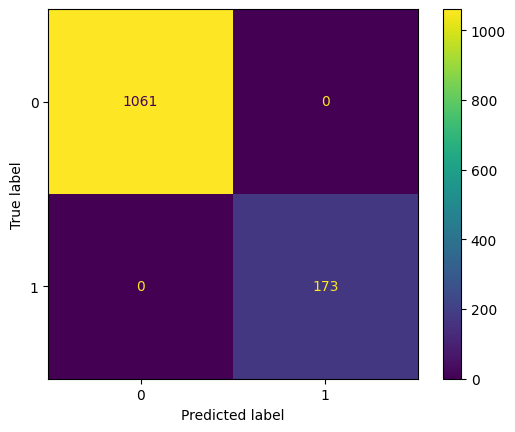


=== Starting Stratified 5-Fold CV ===

--- Fold 1 ---


c:\ProgramData\anaconda3\envs\dl_gpu_env\lib\site-packages\torch\nn\modules\transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch 1/20 | Train F1: 0.7954 | Val F1: 0.9744
Epoch 2/20 | Train F1: 0.9892 | Val F1: 0.9971
Epoch 3/20 | Train F1: 0.9978 | Val F1: 1.0000
Epoch 4/20 | Train F1: 0.9986 | Val F1: 1.0000
Epoch 5/20 | Train F1: 1.0000 | Val F1: 1.0000
Epoch 6/20 | Train F1: 1.0000 | Val F1: 1.0000
Epoch 7/20 | Train F1: 1.0000 | Val F1: 1.0000
Epoch 8/20 | Train F1: 1.0000 | Val F1: 1.0000
Epoch 9/20 | Train F1: 1.0000 | Val F1: 1.0000
Epoch 10/20 | Train F1: 1.0000 | Val F1: 1.0000
Epoch 11/20 | Train F1: 1.0000 | Val F1: 1.0000
Epoch 12/20 | Train F1: 1.0000 | Val F1: 1.0000
Epoch 13/20 | Train F1: 1.0000 | Val F1: 1.0000
Epoch 14/20 | Train F1: 1.0000 | Val F1: 1.0000
Epoch 15/20 | Train F1: 1.0000 | Val F1: 1.0000
Epoch 16/20 | Train F1: 1.0000 | Val F1: 1.0000
Epoch 17/20 | Train F1: 1.0000 | Val F1: 1.0000
Epoch 18/20 | Train F1: 1.0000 | Val F1: 1.0000
Epoch 19/20 | Train F1: 1.0000 | Val F1: 1.0000
Epoch 20/20 | Train F1: 1.0000 | Val F1: 1.0000
Fold 1 Validation: Acc=1.0000 Prec=1.0000 Rec=1.0

c:\ProgramData\anaconda3\envs\dl_gpu_env\lib\site-packages\torch\nn\modules\transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch 1/20 | Train F1: 0.8505 | Val F1: 0.9605
Epoch 2/20 | Train F1: 0.9899 | Val F1: 0.9971
Epoch 3/20 | Train F1: 0.9978 | Val F1: 0.9971
Epoch 4/20 | Train F1: 1.0000 | Val F1: 1.0000
Epoch 5/20 | Train F1: 1.0000 | Val F1: 1.0000
Epoch 6/20 | Train F1: 1.0000 | Val F1: 1.0000
Epoch 7/20 | Train F1: 1.0000 | Val F1: 1.0000
Epoch 8/20 | Train F1: 1.0000 | Val F1: 1.0000
Epoch 9/20 | Train F1: 1.0000 | Val F1: 1.0000
Epoch 10/20 | Train F1: 1.0000 | Val F1: 1.0000
Epoch 11/20 | Train F1: 1.0000 | Val F1: 1.0000
Epoch 12/20 | Train F1: 1.0000 | Val F1: 1.0000
Epoch 13/20 | Train F1: 1.0000 | Val F1: 1.0000
Epoch 14/20 | Train F1: 1.0000 | Val F1: 1.0000
Epoch 15/20 | Train F1: 1.0000 | Val F1: 1.0000
Epoch 16/20 | Train F1: 1.0000 | Val F1: 1.0000
Epoch 17/20 | Train F1: 1.0000 | Val F1: 1.0000
Epoch 18/20 | Train F1: 1.0000 | Val F1: 1.0000
Epoch 19/20 | Train F1: 1.0000 | Val F1: 1.0000
Epoch 20/20 | Train F1: 1.0000 | Val F1: 1.0000
Fold 2 Validation: Acc=1.0000 Prec=1.0000 Rec=1.0

c:\ProgramData\anaconda3\envs\dl_gpu_env\lib\site-packages\torch\nn\modules\transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch 1/20 | Train F1: 0.7814 | Val F1: 0.9632
Epoch 2/20 | Train F1: 0.9892 | Val F1: 0.9942
Epoch 3/20 | Train F1: 0.9993 | Val F1: 0.9942
Epoch 4/20 | Train F1: 1.0000 | Val F1: 0.9942
Epoch 5/20 | Train F1: 1.0000 | Val F1: 0.9942
Epoch 6/20 | Train F1: 1.0000 | Val F1: 1.0000
Epoch 7/20 | Train F1: 1.0000 | Val F1: 1.0000
Epoch 8/20 | Train F1: 1.0000 | Val F1: 1.0000
Epoch 9/20 | Train F1: 1.0000 | Val F1: 1.0000
Epoch 10/20 | Train F1: 1.0000 | Val F1: 1.0000
Epoch 11/20 | Train F1: 1.0000 | Val F1: 1.0000
Epoch 12/20 | Train F1: 1.0000 | Val F1: 1.0000
Epoch 13/20 | Train F1: 1.0000 | Val F1: 1.0000
Epoch 14/20 | Train F1: 1.0000 | Val F1: 1.0000
Epoch 15/20 | Train F1: 1.0000 | Val F1: 1.0000
Epoch 16/20 | Train F1: 1.0000 | Val F1: 1.0000
Epoch 17/20 | Train F1: 1.0000 | Val F1: 1.0000
Epoch 18/20 | Train F1: 1.0000 | Val F1: 1.0000
Epoch 19/20 | Train F1: 1.0000 | Val F1: 1.0000
Epoch 20/20 | Train F1: 1.0000 | Val F1: 1.0000
Fold 3 Validation: Acc=1.0000 Prec=1.0000 Rec=1.0

c:\ProgramData\anaconda3\envs\dl_gpu_env\lib\site-packages\torch\nn\modules\transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch 1/20 | Train F1: 0.7524 | Val F1: 0.9360
Epoch 2/20 | Train F1: 0.9780 | Val F1: 0.9578
Epoch 3/20 | Train F1: 0.9978 | Val F1: 0.9971
Epoch 4/20 | Train F1: 0.9993 | Val F1: 0.9971
Epoch 5/20 | Train F1: 1.0000 | Val F1: 0.9971
Epoch 6/20 | Train F1: 1.0000 | Val F1: 0.9971
Epoch 7/20 | Train F1: 1.0000 | Val F1: 0.9971
Epoch 8/20 | Train F1: 1.0000 | Val F1: 0.9971
Epoch 9/20 | Train F1: 1.0000 | Val F1: 0.9971
Epoch 10/20 | Train F1: 1.0000 | Val F1: 0.9971
Epoch 11/20 | Train F1: 1.0000 | Val F1: 0.9971
Epoch 12/20 | Train F1: 1.0000 | Val F1: 0.9971
Epoch 13/20 | Train F1: 1.0000 | Val F1: 0.9971
Epoch 14/20 | Train F1: 1.0000 | Val F1: 0.9971
Epoch 15/20 | Train F1: 1.0000 | Val F1: 0.9971
Epoch 16/20 | Train F1: 1.0000 | Val F1: 0.9971
Epoch 17/20 | Train F1: 1.0000 | Val F1: 0.9971
Epoch 18/20 | Train F1: 1.0000 | Val F1: 0.9971
Epoch 19/20 | Train F1: 1.0000 | Val F1: 0.9971
Epoch 20/20 | Train F1: 1.0000 | Val F1: 0.9971
Fold 4 Validation: Acc=0.9992 Prec=1.0000 Rec=0.9

c:\ProgramData\anaconda3\envs\dl_gpu_env\lib\site-packages\torch\nn\modules\transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch 1/20 | Train F1: 0.7591 | Val F1: 0.9971
Epoch 2/20 | Train F1: 0.9978 | Val F1: 1.0000
Epoch 3/20 | Train F1: 1.0000 | Val F1: 1.0000
Epoch 4/20 | Train F1: 1.0000 | Val F1: 1.0000
Epoch 5/20 | Train F1: 1.0000 | Val F1: 1.0000
Epoch 6/20 | Train F1: 1.0000 | Val F1: 1.0000
Epoch 7/20 | Train F1: 1.0000 | Val F1: 1.0000
Epoch 8/20 | Train F1: 1.0000 | Val F1: 1.0000
Epoch 9/20 | Train F1: 1.0000 | Val F1: 1.0000
Epoch 10/20 | Train F1: 1.0000 | Val F1: 1.0000
Epoch 11/20 | Train F1: 1.0000 | Val F1: 1.0000
Epoch 12/20 | Train F1: 1.0000 | Val F1: 1.0000
Epoch 13/20 | Train F1: 1.0000 | Val F1: 1.0000
Epoch 14/20 | Train F1: 1.0000 | Val F1: 1.0000
Epoch 15/20 | Train F1: 1.0000 | Val F1: 1.0000
Epoch 16/20 | Train F1: 1.0000 | Val F1: 1.0000
Epoch 17/20 | Train F1: 1.0000 | Val F1: 1.0000
Epoch 18/20 | Train F1: 1.0000 | Val F1: 1.0000
Epoch 19/20 | Train F1: 1.0000 | Val F1: 1.0000
Epoch 20/20 | Train F1: 1.0000 | Val F1: 1.0000
Fold 5 Validation: Acc=1.0000 Prec=1.0000 Rec=1.0

In [104]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, ConfusionMatrixDisplay
from os import path
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# 1. Load data and drop leakage columns (assuming df is loaded already)
df = pd.read_csv(path.join('dataset', 'EVSE-B-HPC-Kernel-Events-processed.csv'))
corr = df.corr()
leak_cols = [col for col in corr['isDoS'].index if (corr['isDoS'][col] > 0.9 and col != 'isDoS')]
print("Leakage columns dropped:", leak_cols)

df_filtered = df.drop(columns=leak_cols)

# 2. Prepare features and labels
X = df_filtered.drop(columns=['isDoS']).values
y = df_filtered['isDoS'].astype(int).values

# 3. Standard scaling on whole dataset before split (or inside CV fold)
scaler = StandardScaler()
X = scaler.fit_transform(X)

# 4. Define Dataset class
class EVSEDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.long)
    def __len__(self):
        return len(self.y)
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# 5. Define your hybrid transformer model
class HybridTransformerClassifier(nn.Module):
    def __init__(self, input_dim, embed_dim=16, num_heads=4, hidden_dim=128, num_layers=1):
        super(HybridTransformerClassifier, self).__init__()
        self.embedding = nn.Linear(input_dim, embed_dim)
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=embed_dim, nhead=num_heads, dim_feedforward=hidden_dim
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.mlp = nn.Sequential(
            nn.Linear(embed_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 2)
        )
    def forward(self, x):
        # x shape: (batch_size, input_dim)
        x = self.embedding(x).unsqueeze(1)  # (B, 1, embed_dim)
        x = self.transformer(x).squeeze(1)  # (B, embed_dim)
        out = self.mlp(x)                   # (B, 2)
        return out

# 6. Training and Evaluation functions
def train_one_epoch(model, optimizer, criterion, loader):
    model.train()
    total_loss = 0
    preds, trues = [], []
    for xb, yb in loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        logits = model(xb)
        loss = criterion(logits, yb)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        pred = logits.argmax(dim=1).detach().cpu().numpy()
        preds.extend(pred)
        trues.extend(yb.detach().cpu().numpy())
    acc = accuracy_score(trues, preds)
    prec = precision_score(trues, preds)
    rec = recall_score(trues, preds)
    f1 = f1_score(trues, preds)
    return total_loss / len(loader), acc, prec, rec, f1

def eval_model(model, loader):
    model.eval()
    preds, trues = [], []
    with torch.no_grad():
        for xb, yb in loader:
            xb = xb.to(device)
            out = model(xb)
            pred = out.argmax(1).cpu().numpy()
            preds.extend(pred)
            trues.extend(yb.numpy())
    acc = accuracy_score(trues, preds)
    prec = precision_score(trues, preds)
    rec = recall_score(trues, preds)
    f1 = f1_score(trues, preds)
    return acc, prec, rec, f1, preds, trues

# 7. Split train/test dataset
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)
train_dataset = EVSEDataset(X_train, y_train)
test_dataset = EVSEDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64)

# 8. Instantiate model, criterion, optimizer
model = HybridTransformerClassifier(input_dim=X.shape[1]).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# 9. Training loop with best model saving
best_f1 = 0
num_epochs = 20

train_losses, val_losses = [], []

for epoch in range(num_epochs):
    train_loss, train_acc, train_prec, train_rec, train_f1 = train_one_epoch(model, optimizer, criterion, train_loader)
    val_acc, val_prec, val_rec, val_f1, _, _ = eval_model(model, test_loader)
    
    print(f"Epoch {epoch+1}/{num_epochs} | Train Loss: {train_loss:.4f} | Train F1: {train_f1:.4f} | Val F1: {val_f1:.4f} | Val Acc: {val_acc:.4f}")
    
    train_losses.append(train_loss)
    val_losses.append(1 - val_f1)  # or validation loss if you want
    
    if val_f1 > best_f1:
        best_f1 = val_f1
        torch.save(model.state_dict(), "best_evse_model.pth")

# 10. Load best model and evaluate final test metrics
model.load_state_dict(torch.load("best_evse_model.pth"))
acc, prec, rec, f1, preds, trues = eval_model(model, test_loader)

print("\n✅ Final Test Set Evaluation:")
print(f"Accuracy:  {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall:    {rec:.4f}")
print(f"F1-score:  {f1:.4f}")

# 11. Plot confusion matrix
ConfusionMatrixDisplay.from_predictions(trues, preds)
plt.show()

# (Optional) 12. Stratified K-Fold Cross-Validation similar to their code
print("\n=== Starting Stratified 5-Fold CV ===")
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
fold_metrics = []

for fold, (train_idx, val_idx) in enumerate(skf.split(X, y), 1):
    print(f"\n--- Fold {fold} ---")
    X_train_fold, X_val_fold = X[train_idx], X[val_idx]
    y_train_fold, y_val_fold = y[train_idx], y[val_idx]
    
    # Scale inside fold
    scaler_fold = StandardScaler()
    X_train_fold = scaler_fold.fit_transform(X_train_fold)
    X_val_fold = scaler_fold.transform(X_val_fold)
    
    train_ds = EVSEDataset(X_train_fold, y_train_fold)
    val_ds = EVSEDataset(X_val_fold, y_val_fold)
    
    train_loader_fold = DataLoader(train_ds, batch_size=64, shuffle=True)
    val_loader_fold = DataLoader(val_ds, batch_size=64)
    
    model_fold = HybridTransformerClassifier(input_dim=X.shape[1]).to(device)
    criterion_fold = nn.CrossEntropyLoss()
    optimizer_fold = optim.Adam(model_fold.parameters(), lr=1e-3)
    
    best_f1_fold = 0
    best_model_state_fold = None
    
    for epoch in range(num_epochs):
        train_loss, train_acc, train_prec, train_rec, train_f1 = train_one_epoch(model_fold, optimizer_fold, criterion_fold, train_loader_fold)
        val_acc, val_prec, val_rec, val_f1, _, _ = eval_model(model_fold, val_loader_fold)
        print(f"Epoch {epoch+1}/{num_epochs} | Train F1: {train_f1:.4f} | Val F1: {val_f1:.4f}")
        
        if val_f1 > best_f1_fold:
            best_f1_fold = val_f1
            best_model_state_fold = model_fold.state_dict()
    
    model_fold.load_state_dict(best_model_state_fold)
    acc, prec, rec, f1, _, _ = eval_model(model_fold, val_loader_fold)
    print(f"Fold {fold} Validation: Acc={acc:.4f} Prec={prec:.4f} Rec={rec:.4f} F1={f1:.4f}")
    fold_metrics.append((acc, prec, rec, f1))

fold_metrics = np.array(fold_metrics)
print("\n=== Cross-Validation Results ===")
print(f"Accuracy:  {fold_metrics[:,0].mean():.4f} ± {fold_metrics[:,0].std():.4f}")
print(f"Precision: {fold_metrics[:,1].mean():.4f} ± {fold_metrics[:,1].std():.4f}")
print(f"Recall:    {fold_metrics[:,2].mean():.4f} ± {fold_metrics[:,2].std():.4f}")
print(f"F1-score:  {fold_metrics[:,3].mean():.4f} ± {fold_metrics[:,3].std():.4f}")


Class distribution in full dataset:
0    0.859715
1    0.140285
Name: proportion, dtype: float64


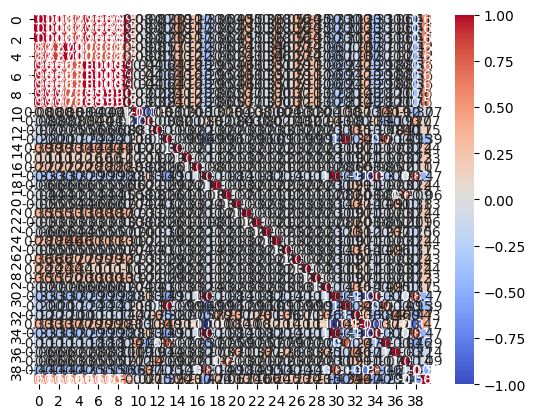

In [105]:
print("Class distribution in full dataset:")
print(pd.Series(y).value_counts(normalize=True))

# Check correlation heatmap:
import seaborn as sns
import matplotlib.pyplot as plt
sns.heatmap(pd.DataFrame(X).corr(), annot=True, fmt=".2f", cmap='coolwarm')
plt.show()

# Try 5-fold CV with your existing code to check stability of perfect scores.
